In [1]:
import numpy as np
import torch
import os
import sys
import random
import matplotlib.pyplot as plt
import torch.nn.functional as F

from torch.utils.data import DataLoader

module_path = os.path.abspath(os.path.join('..'))
sys.path.append(module_path+"/models")
sys.path.append(module_path+"/train")
sys.path.append(module_path+"/datasets")

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [16]:
from datasets import train_test_random_split, load_dsprites, CustomDSpritesDatasetFactorVAE
from train import train_beta_vae, test_beta_vae
from loss import loss_beta_vae
from beta_vae import BetaVAEDSprites, Classifier
from utils import latent_transversal, load_checkpoint
from entanglement_metric import entanglement_metric_factor_vae, entanglement_metric_beta_vae

In [18]:
whole_dataset = load_dsprites("../datasets/dsprites.npz", False)
dataset = whole_dataset['imgs']
dataset = torch.from_numpy(dataset)

In [13]:
batch_size = 64
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True)

In [14]:
model = BetaVAEDSprites()
model.to(device)

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [15]:
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)

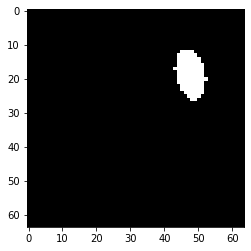

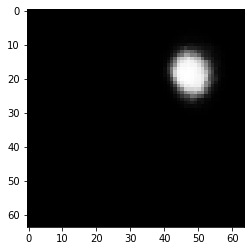

In [30]:
index = 100
original = dataset[index].float().to(device)
recon, mu, logvar = model(original)
plt.imshow(original.cpu(), cmap='Greys_r')
plt.show()
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [5]:
len(dataset) / 64

11520.0

None


In [9]:
def compute_latent_gaussian_variance(model, dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=True)
    accumulator = torch.zeros(10)
    with torch.no_grad():
        for index, data in enumerate(loader):
            # shape of data is 64 x img_size
            _, _, logvar = model(data.float())
            accumulator = accumulator + logvar.div(2).exp().sum(0)
            if index % 1000 == 999:
                print('.', end='')
            del logvar
    return accumulator.div(len(dataset))

In [30]:
model_beta1_e40_alldata = torch.load('trained_models/betavae_beta1_e40_alldata.dat')
model_beta1_e40_alldata.cpu()
model_beta1_e40_alldata.eval()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  6.  4.  1.  2.  5.  0.  0.  4.  0.]
 [ 0.  0.  4.  0. 10.  0.  0.  0.  2.  0.]
 [ 4.  0.  4.  3.  2.  0.  0.  7.  0.  3.]
 [ 1.  0.  3.  0.  0.  0.  6.  1.  0.  8.]
 [20.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
Factor Vae metric: 
Accuracy: 0.51
Beta Vae metric: 
Epoch 0 finished, loss: 1.6710106402635574, accuracy:0.16375
Epoch 1 finished, loss: 1.6667605459690094, accuracy:0.165
Epoch 2 finished, loss: 1.662931926548481, accuracy:0.16875
Epoch 3 finished, loss: 1.6594409078359604, accuracy:0.1675
Epoch 4 finished, loss: 1.6560884535312652, accuracy:0.17
Epoch 5 finished, loss: 1.6530262008309364, accuracy:0.17
Epoch 6 finished, loss: 1.650194674730301, accuracy:0.17125
Epoch 7 finished, loss: 1.6475941717624665, accuracy:0.1675
Epoch 8 finished, loss: 1.6451336145401, accuracy:0.1675
Epoch 9 finished, loss: 1.6429397389292717, accuracy:0.16625
Epoch 10 finished, loss: 1.640892541408539, accuracy:0.165
Epoch 11 finished, loss: 1.63889794

Epoch 134 finished, loss: 1.5781890124082565, accuracy:0.2475
Epoch 135 finished, loss: 1.5779826655983924, accuracy:0.2475
Epoch 136 finished, loss: 1.5776745676994324, accuracy:0.24625
Epoch 137 finished, loss: 1.5774048954248427, accuracy:0.25
Epoch 138 finished, loss: 1.5771436408162116, accuracy:0.24875
Epoch 139 finished, loss: 1.576828770339489, accuracy:0.25125
Epoch 140 finished, loss: 1.5765441060066223, accuracy:0.2525
Epoch 141 finished, loss: 1.5762665003538132, accuracy:0.25
Epoch 142 finished, loss: 1.575998416543007, accuracy:0.2525
Epoch 143 finished, loss: 1.5757728219032288, accuracy:0.25375
Epoch 144 finished, loss: 1.5754419967532158, accuracy:0.255
Epoch 145 finished, loss: 1.5751987248659134, accuracy:0.25875
Epoch 146 finished, loss: 1.574925796687603, accuracy:0.2625
Epoch 147 finished, loss: 1.5746350452303886, accuracy:0.26
Epoch 148 finished, loss: 1.5744030624628067, accuracy:0.26125
Epoch 149 finished, loss: 1.5741095140576362, accuracy:0.26375
Epoch 150 f

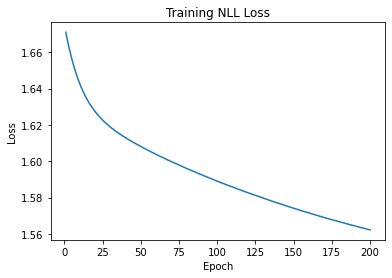

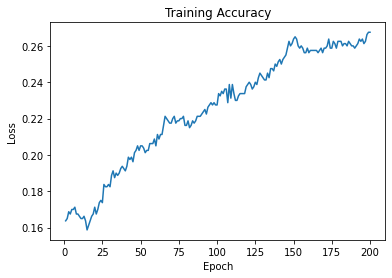

In [31]:
loss = entanglement_metric_factor_vae(model_beta1_e40_alldata, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta1_e40_alldata, classifier, optimizer, 200,  data_, 1000, 10)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

In [13]:
latent_gaussian_variance_beta1 = compute_latent_gaussian_variance(model_beta1_e40_alldata, dataset)

...........

In [14]:
print(latent_gaussian_variance_beta1)

tensor([0.0094, 0.0634, 0.0134, 0.0451, 0.0390, 0.0524, 0.0099, 0.0142, 0.1327,
        0.0124])


In [1]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float().to(device)


NameError: name 'np' is not defined

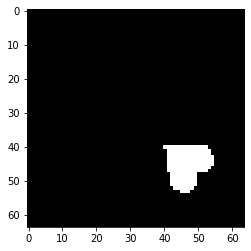

In [17]:
plt.imshow(torch.sigmoid(original.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

In [18]:
recon, mu, logvar = model_beta1_e40_alldata(original)

In [19]:
logvar.div(2).exp()

tensor([[0.0094, 0.0554, 0.0182, 0.0401, 0.0399, 0.0454, 0.0093, 0.0220, 0.2406,
         0.0106]], device='cuda:0', grad_fn=<ExpBackward>)

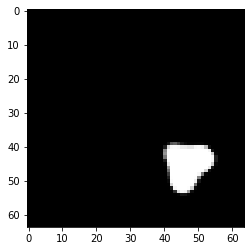

In [21]:
plt.imshow(torch.sigmoid(recon.cpu().detach()).view(64,64), cmap='Greys_r')
plt.show()

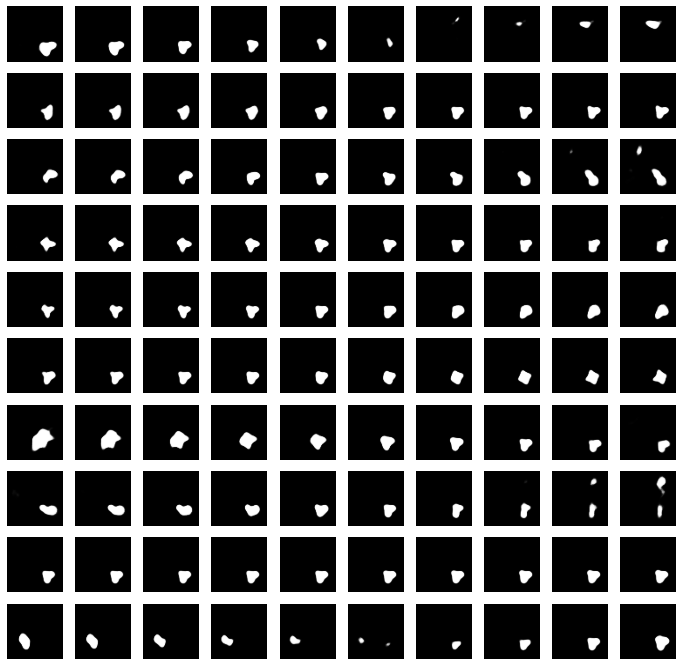

In [20]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model_beta1_e40_alldata, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [5]:
from utils import save_checkpoint, load_checkpoint

In [9]:
model = BetaVAEDSprites()
model.to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=1e-2)
losslogger = []

In [11]:
model_beta4_e100, optimizer, start_epoch, losslogger = load_checkpoint(
    model, optimizer, losslogger,
    'trained_models/betavae_beta4_e100_alldata.pth.tar')

=> loading checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar'
=> loaded checkpoint 'trained_models/betavae_beta4_e100_alldata.pth.tar' (epoch 101)


In [12]:
model_beta4_e100(dataset[0].float().to(device))

(tensor([[-22.1766, -21.6752, -22.0266,  ..., -22.2811, -22.0703, -21.9393]],
        device='cuda:0', grad_fn=<AddmmBackward>),
 tensor([[ 0.6407,  0.3896,  1.2050, -0.0108, -0.7347,  1.5645,  0.0088, -0.5321,
           0.7589, -0.0401]], device='cuda:0', grad_fn=<SliceBackward>),
 tensor([[-5.9687, -4.9327, -6.1625, -0.0626, -6.8360, -7.9847, -0.0889, -8.4066,
          -8.3986, -0.0898]], device='cuda:0', grad_fn=<SliceBackward>))

In [25]:
latent_gaussian_variance_beta4 = compute_latent_gaussian_variance(model_beta4_e100, dataset)
print(latent_gaussian_variance_beta4)

...........tensor([0.0414, 0.0913, 0.0380, 0.9566, 0.0316, 0.0158, 0.9635, 0.0189, 0.0130,
        0.9602])


In [13]:
index = np.random.randint(0, len(dataset))
original = dataset[index].float().to(device)


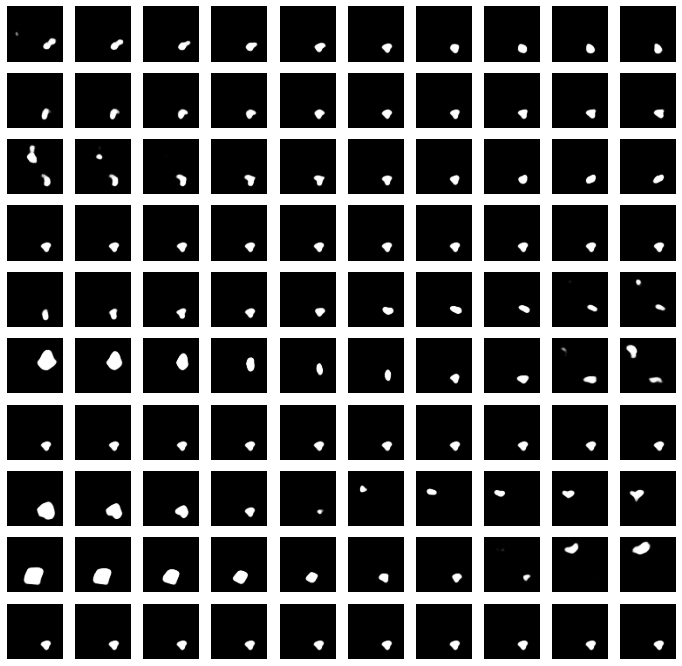

In [14]:
fig = plt.figure(figsize=[12, 12])
for i in range(10):
    imgs = latent_transversal(model, original, -3, 3, 10, i)
    for j, img in enumerate(imgs):
        plt.subplot(10, 10, i * 10 + j + 1)
        plt.axis('off')
        plt.imshow(torch.sigmoid(img.detach()).view(64,64), cmap='Greys_r')
plt.show()

In [19]:
data_size = 10000
data_ = CustomDSpritesDatasetFactorVAE(whole_dataset, data_size)

In [21]:
model_beta4_e100.cpu()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

In [23]:
def plot_loss(loss_list, title):
    plt.plot(np.arange(1,len(loss_list)+1, 1), loss_list)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training "+title)
    plt.show()

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 9.  9.  0.  0.  0.  2.  0.  2.  2.  0.]
 [ 0.  4.  6.  3.  0.  0.  1.  0.  0.  3.]
 [14.  1.  0.  0.  4.  0.  0.  0.  5.  0.]
 [ 0.  0.  2.  0.  6.  6.  0.  2.  0.  0.]
 [ 0.  0.  0.  0.  3.  4.  0.  2. 10.  0.]]
Factor Vae metric: 
Accuracy: 0.44999999999999996
Beta Vae metric: 
Epoch 0 finished, loss: 1.6275816917419434, accuracy:0.1925
Epoch 1 finished, loss: 1.626277008652687, accuracy:0.19625
Epoch 2 finished, loss: 1.625090028345585, accuracy:0.19625
Epoch 3 finished, loss: 1.6239756524562836, accuracy:0.19625
Epoch 4 finished, loss: 1.6228930607438088, accuracy:0.19375
Epoch 5 finished, loss: 1.6219044610857964, accuracy:0.195
Epoch 6 finished, loss: 1.6209238588809967, accuracy:0.195
Epoch 7 finished, loss: 1.6200217470526694, accuracy:0.19125
Epoch 8 finished, loss: 1.6191286817193031, accuracy:0.1925
Epoch 9 finished, loss: 1.6182975947856904, accuracy:0.19125
Epoch 10 finished, loss: 1.6175555661320686, accuracy:0.195
Epoch 11 fi

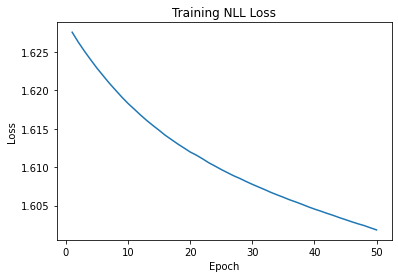

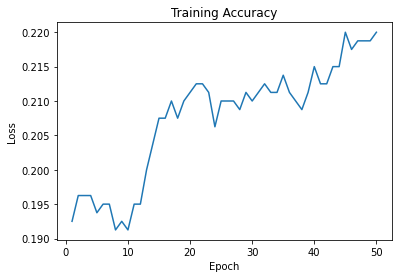

In [24]:
loss = entanglement_metric_factor_vae(model_beta4_e100, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta4_e100, classifier, optimizer, 50,  data_, 1000, 10)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")

In [27]:
model_beta4_e40_alldata = torch.load('trained_models/betavae_beta4_e40_alldata.dat')
model_beta4_e40_alldata.cpu()

BetaVAEDSprites(
  (encoder): Sequential(
    (0): Linear(in_features=4096, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=1200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=1200, out_features=4096, bias=True)
  )
)

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 16.  8.  0.  3.  0.  0.  0.  0.]
 [ 2.  0.  3.  0.  0. 11.  4.  0.  0.  6.]
 [ 0.  0. 10.  2.  0.  3.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  8.  0.  0.  7.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 16.  0.]]
Factor Vae metric: 
Accuracy: 0.61
Beta Vae metric: 
Epoch 0 finished, loss: 1.6715067833662034, accuracy:0.1725
Epoch 1 finished, loss: 1.667233557999134, accuracy:0.17125
Epoch 2 finished, loss: 1.6632487550377846, accuracy:0.1725
Epoch 3 finished, loss: 1.6594988226890564, accuracy:0.17375
Epoch 4 finished, loss: 1.6559909299015998, accuracy:0.17375
Epoch 5 finished, loss: 1.6527004778385161, accuracy:0.17375
Epoch 6 finished, loss: 1.6496044412255286, accuracy:0.1675
Epoch 7 finished, loss: 1.6466932490468025, accuracy:0.16625
Epoch 8 finished, loss: 1.643994389474392, accuracy:0.16875
Epoch 9 finished, loss: 1.6413757890462874, accuracy:0.1725
Epoch 10 finished, loss: 1.6389542564749717, accuracy:0.1725
Epoch 11 finished, loss

Epoch 131 finished, loss: 1.565345761179924, accuracy:0.3025
Epoch 132 finished, loss: 1.5650042921304703, accuracy:0.30375
Epoch 133 finished, loss: 1.5647007644176483, accuracy:0.30375
Epoch 134 finished, loss: 1.5643965259194375, accuracy:0.305
Epoch 135 finished, loss: 1.5640531063079834, accuracy:0.305
Epoch 136 finished, loss: 1.5637504518032075, accuracy:0.305
Epoch 137 finished, loss: 1.5634283050894737, accuracy:0.305
Epoch 138 finished, loss: 1.563120184838772, accuracy:0.30625
Epoch 139 finished, loss: 1.5627879217267036, accuracy:0.30625
Epoch 140 finished, loss: 1.5624735668301581, accuracy:0.305
Epoch 141 finished, loss: 1.562188918888569, accuracy:0.30375
Epoch 142 finished, loss: 1.5618487000465393, accuracy:0.305
Epoch 143 finished, loss: 1.5615535020828246, accuracy:0.30375
Epoch 144 finished, loss: 1.561227560043335, accuracy:0.30625
Epoch 145 finished, loss: 1.5609609976410865, accuracy:0.30625
Epoch 146 finished, loss: 1.5606245830655099, accuracy:0.30625
Epoch 147

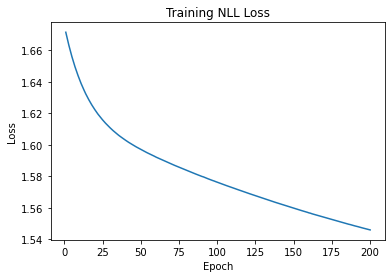

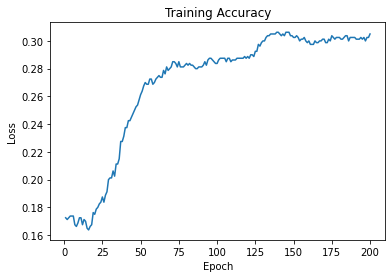

In [29]:
loss = entanglement_metric_factor_vae(model_beta4_e40_alldata, data_, 100, 1000)
print("Factor Vae metric: ")
print("Accuracy: "+str(1-loss))
print("Beta Vae metric: ")
classifier = Classifier()
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
losses, accuracies = entanglement_metric_beta_vae(model_beta4_e40_alldata, classifier, optimizer, 200,  data_, 1000, 10)
plot_loss(losses, "NLL Loss")
plot_loss(accuracies, "Accuracy")